In [14]:
import pandas as pd
import dask.dataframe as dd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import roc_curve, auc
import dataframe_image as dfi

# Paths

In [15]:
processed_dir = os.path.join( "..", "data", "processed")

final_dataset_path = os.path.join(processed_dir, 'FEData_For_Modelling.parquet')

minority_users_dt_pq = os.path.join(processed_dir, 'minority_users_dt.parquet')
minority_users_smote_dt_pq = os.path.join(processed_dir, 'minority_users_dt_smote.parquet')

minority_users_svm_pq = os.path.join(processed_dir, 'minority_users_svm.parquet')
minority_users_smote_svm_pq = os.path.join(processed_dir, 'minority_users_svm_smote.parquet')

minority_users_nn_pq = os.path.join(processed_dir, 'minority_users_nn.parquet')
minority_users_smote_nn_pq = os.path.join(processed_dir, 'minority_users_nn_smote.parquet')

minority_users_em_pq = os.path.join(processed_dir, 'minority_users_em_pq.parquet')

# Load Figures
load_figures_dir = os.path.join( "..", "materials", "reports", "figures")

dt_confusion_matrix_path = os.path.join(load_figures_dir, "3A", "dt_confusion_matrix.png")
svm_confusion_matrix_path = os.path.join(load_figures_dir, "3C", "svm_confusion_matrix.png")
nn_confusion_matrix_path = os.path.join(load_figures_dir, "3E", "nn_confusion_matrix.png")
em_confusion_matrix_path = os.path.join(load_figures_dir, "3G", "em_confusion_matrix.png")

dt_smote_confusion_matrix_path = os.path.join(load_figures_dir, "3B", "dt_smote_confusion_matrix.png")
svm_smote_confusion_matrix_path = os.path.join(load_figures_dir, "3D", "svm_smote_confusion_matrix.png")
nn_smote_confusion_matrix_path = os.path.join(load_figures_dir, "3F", "nn_confusion_matrix.png")

dt_train_confidence_score_path = os.path.join(load_figures_dir, "3A", "dt_train_confidence_score.png")
svm_train_confidence_score_path = os.path.join(load_figures_dir, "3C", "svm_train_confidence_score.png")
nn_train_confidence_score_path = os.path.join(load_figures_dir, "3E", "nn_train_confidence_score.png")

dt_test_confidence_score_path = os.path.join(load_figures_dir, "3A", "dt_test_confidence_score.png")
svm_test_confidence_score_path = os.path.join(load_figures_dir, "3C", "svm_test_confidence_score.png")
nn_test_confidence_score_path = os.path.join(load_figures_dir, "3E", "nn_test_confidence_score.png")
em_test_confidence_score_path = os.path.join(load_figures_dir, "3G", "em_test_confidence_score.png")

dt_smote_train_confidence_score_path = os.path.join(load_figures_dir, "3B", "dt_smote_train_confidence_score.png")
svm_smote_train_confidence_score_path = os.path.join(load_figures_dir, "3D", "svm_smote_train_confidence_score.png")
nn_smote_train_confidence_score_path = os.path.join(load_figures_dir, "3F", "nn_train_confidence_score.png")

dt_smote_test_confidence_score_path = os.path.join(load_figures_dir, "3B", "dt_smote_test_confidence_score.png")
svm_smote_test_confidence_score_path = os.path.join(load_figures_dir, "3D", "svm_smote_test_confidence_score.png")
nn_smote_test_confidence_score_path = os.path.join(load_figures_dir, "3F", "nn_test_confidence_score.png")

# Create Figures
figures_dir = os.path.join( "..", "materials", "reports", "figures", "4")

bar_graph_minority_path = os.path.join(figures_dir, 'bar_graph_minority.png')
bar_graph_minority_smote_path = os.path.join(figures_dir, 'bar_graph_minority_smote.png')
combined_minority_path = os.path.join(figures_dir, 'combined_minority.png')

combined_metrics_path = os.path.join(figures_dir, 'combined_metrics.png')

roc_curves_smote_path = os.path.join(figures_dir, 'roc_curves_smote.png')
roc_curves_path = os.path.join(figures_dir, 'roc_curves.png')
combined_roc_curves_path = os.path.join(figures_dir, 'combined_roc_curves.png')

confusion_matrix_path = os.path.join(figures_dir, 'confusion_matrix.png')
smote_confusion_matrix_path = os.path.join(figures_dir, 'smote_confusion_matrix.png')

train_confidence_score_path = os.path.join(figures_dir, 'train_confidence_score_path')
test_confidence_score_path = os.path.join(figures_dir, 'test_confidence_score_path')

smote_train_confidence_score_path = os.path.join(figures_dir, 'smote_train_confidence_score_path')
smote_test_confidence_score_path = os.path.join(figures_dir, 'smote_test_confidence_score_path')

Import Dataset

In [16]:
# Read the multi-part Parquet dataset
dt_data = dd.read_parquet(minority_users_dt_pq)
smote_dt_data = dd.read_parquet(minority_users_smote_dt_pq)

svm_data = dd.read_parquet(minority_users_svm_pq)
smote_svm_data = dd.read_parquet(minority_users_smote_svm_pq)

nn_data = dd.read_parquet(minority_users_nn_pq)
smote_nn_data = dd.read_parquet(minority_users_smote_nn_pq)

em_data = dd.read_parquet(minority_users_em_pq)

dt_data.head(4000)

,user,Actual,Prediction,Decision Path,GINI Confidence of Prediction,normal_prob,malicious_prob
0,VAH1292,False,False,"[0, 1, 2, 4]",1.110223e-16,0.925581,0.074419
1,CJL0143,False,False,"[0, 1, 2, 3]",1.712135e-01,0.996160,0.003840
2,MMB1967,False,False,"[0, 1, 2, 3]",1.712135e-01,0.996160,0.003840
3,IVS1411,False,False,"[0, 1, 2, 3]",1.712135e-01,0.996160,0.003840
4,MEB1743,False,False,"[0, 1, 2, 4]",1.110223e-16,0.925581,0.074419
...,...,...,...,...,...,...,...
395,JIG1593,False,False,"[0, 1, 2, 3]",1.712135e-01,0.996160,0.003840
396,MDL0294,False,False,"[0, 1, 2, 3]",1.712135e-01,0.996160,0.003840
397,SSG0726,False,False,"[0, 1, 2, 3]",1.712135e-01,0.996160,0.003840
398,BWJ1539,False,False,"[0, 1, 5, 6]",5.350830e-01,0.968254,0.031746


# Calculations

In [17]:
def get_confusion_matrix_score(data):
    TN = len(data[(data['Actual'] == False) & (data['Prediction'] == False)])
    FP = len(data[(data['Actual'] == False) & (data['Prediction'] == True)])
    FN = len(data[(data['Actual'] == True) & (data['Prediction'] == False)])
    TP = len(data[(data['Actual'] == True) & (data['Prediction'] == True)])
    return TN, FP, FN, TP

get_confusion_matrix_score(dt_data)

(396, 0, 4, 0)

In [19]:
def get_model_scores_df(dt_data, svm_data, nn_data, em_data):
    model_scores = pd.DataFrame(columns = ['TN', 'FP', 'FN', 'TP'])
    model_data = [dt_data, svm_data, nn_data, em_data]

    for data in model_data:
        TN, FP, FN, TP = get_confusion_matrix_score(data)
        model_scores.loc[len(model_scores.index)] = [TN, FP, FN, TP]

    model_scores.index = ['Decision Tree', 'SVM', 'Neural Network', 'Ensemble Model']
    return model_scores

model_scores_df = get_model_scores_df(dt_data, svm_data, nn_data, em_data)
smote_model_scores_df = get_model_scores_df(smote_dt_data, smote_svm_data, smote_nn_data, em_data)
smote_model_scores_df

,TN,FP,FN,TP
Decision Tree,387,9,2,2
SVM,394,2,3,1
Neural Network,392,4,3,1
Ensemble Model,394,2,2,2


# Graph of Minority cases (FP/FN/TP) 

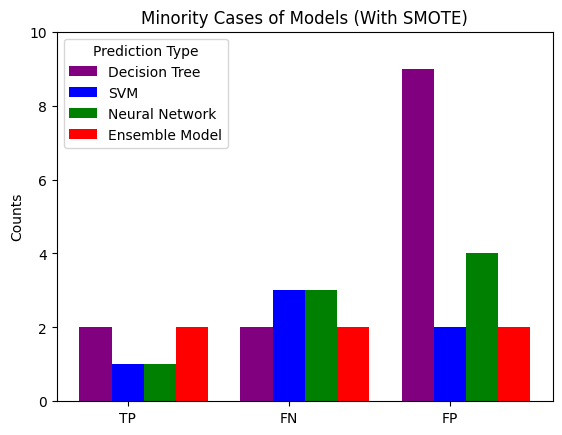

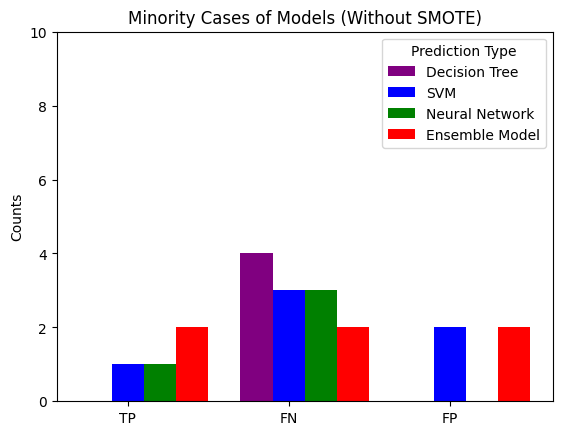

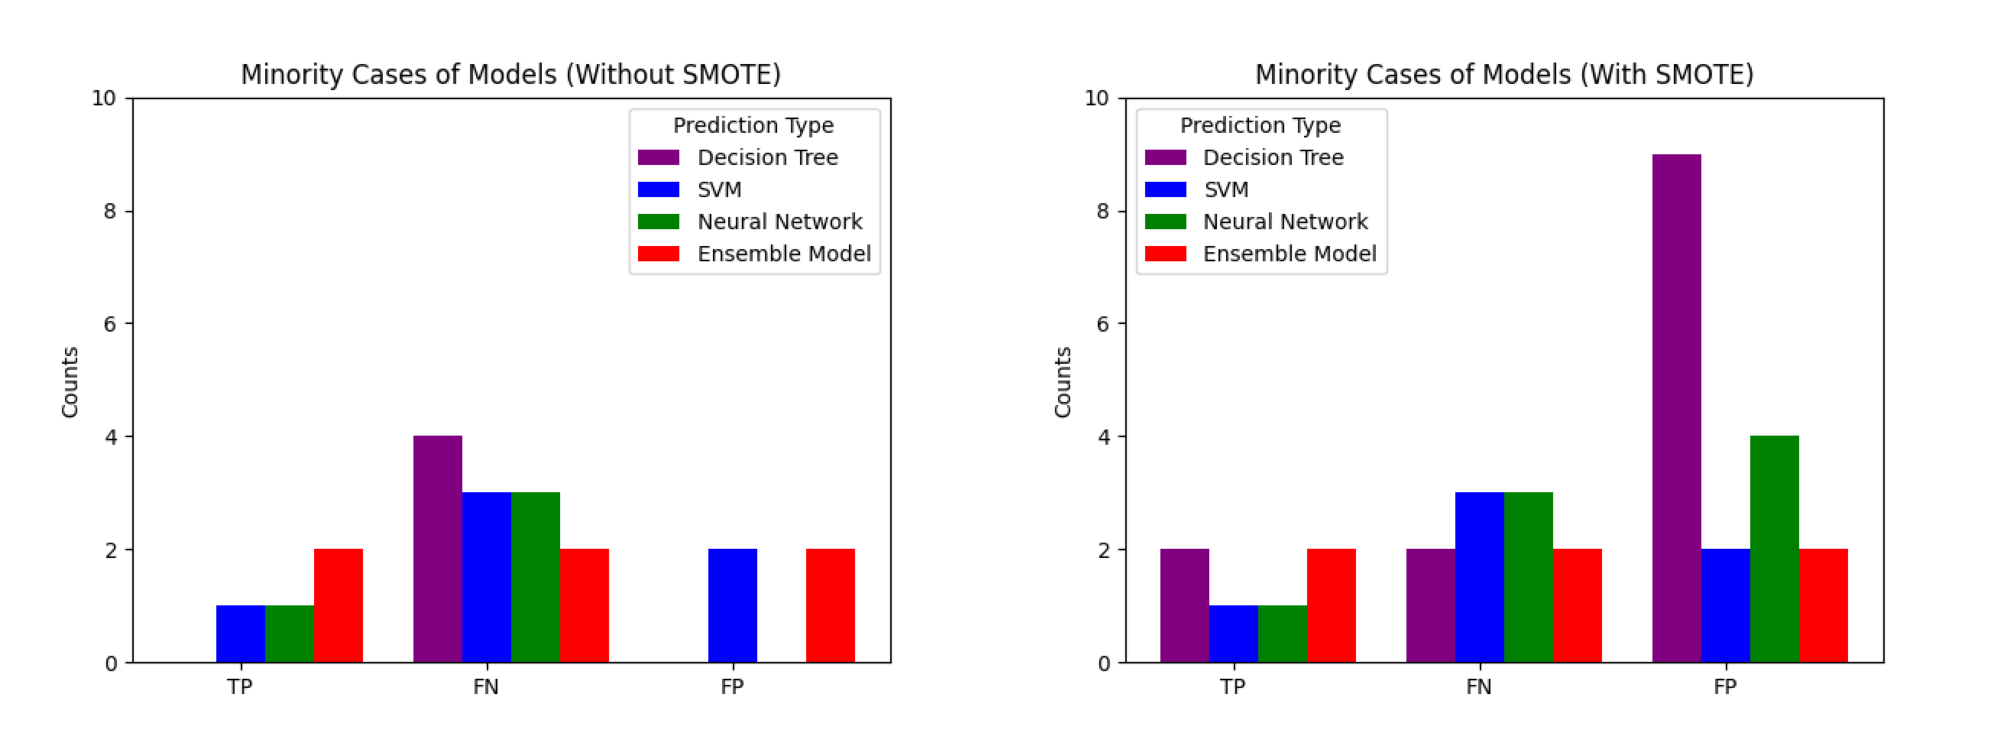

In [20]:
models = ['Decision Tree', 'SVM', 'Neural Network', 'Ensemble Model']

selected_columns = ['TP', 'FN', 'FP']

def minority_plots(selected_columns, models, df, title, path):
    fig, ax = plt.subplots()

    # Define colors for each model
    colors = {'Decision Tree': 'purple', 'SVM': 'blue', 'Neural Network': 'green', 'Ensemble Model': 'red'}

    for i, model in enumerate(models):
        ax.bar(
            x=[x + i * 0.2 for x in range(len(selected_columns))], 
            height=df.loc[model].iloc[-3:][::-1], 
            width=0.2, 
            label=model,
            color = colors[model]
        )
    ax.set_xticks([x + 0.2 for x in range(len(selected_columns))])
    ax.set_xticklabels(selected_columns)
    ax.set_title(title)
    ax.set_ylabel('Counts')
    ax.legend(title="Prediction Type")
    ax.set_ylim(0,10)
    plt.savefig(path)
    plt.show()

minority_plots(selected_columns, models, smote_model_scores_df,  'Minority Cases of Models (With SMOTE)', bar_graph_minority_smote_path)
minority_plots(selected_columns, models, model_scores_df, 'Minority Cases of Models (Without SMOTE)', bar_graph_minority_path)

def combine_plots(plot_paths, plot_title, save_file_path, figsize, y, x, fontsize):
    fig, ax = plt.subplots(1, len(plot_paths), figsize=figsize)
    plt.suptitle(plot_title, fontweight = "bold", y = y, x = x, fontsize = fontsize)

    for i, path in enumerate(plot_paths):
        ax[i].imshow(mpimg.imread(path))
        ax[i].axis('off')
        
    plt.tight_layout()
    plt.savefig(save_file_path)
    plt.show()

combine_plots([bar_graph_minority_path, bar_graph_minority_smote_path], "", combined_minority_path, (20, 10), 0.68, 0.15, 14)


# Combined table of 'Accuracy', 'Precision', 'Recall', 'F1 Score'

In [21]:
def calculate_metrics(df):
    df['Accuracy %'] = (df['TP'] + df['TN']) / (df['TN'] + df['FP'] + df['FN'] + df['TP'])
    df['Precision %'] = df['TP'] / (df['TP'] + df['FP']).replace(0, 1)
    df['Recall %'] = df['TP'] / (df['TP'] + df['FN']).replace(0, 1)
    df['F1 Score %'] = 2 * (df['Precision %'] * df['Recall %']) / (df['Precision %'] + df['Recall %']).replace(0, 1)
    return df[['Accuracy %', 'Precision %', 'Recall %', 'F1 Score %']]
    
def generate_metrics_table(smote_df, no_smote_df, model_names):
    smote_metrics = calculate_metrics(smote_df.loc[:smote_df.index[-2]])
    no_smote_metrics = calculate_metrics(no_smote_df.loc[:no_smote_df.index[-2]])
    em_metrics = calculate_metrics(smote_df.loc[smote_df.index[-1]:])

    smote_metrics.index = [model + ' (SMOTE)' for model in model_names]
    no_smote_metrics.index = [model + ' (No SMOTE)' for model in model_names]
    em_metrics.index = ['Ensemble Model']

    metrics_table = pd.concat([no_smote_metrics, smote_metrics, em_metrics])
    
    return metrics_table

model_names = ['Decision Tree', 'SVM', 'Neural Network']
metrics_table = generate_metrics_table(smote_model_scores_df, model_scores_df, model_names)
metrics_table = metrics_table*100

# Function to apply styling
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

# Apply styling
metrics_table = metrics_table.style.apply(highlight_max).format('{:.2f}')

dfi.export(metrics_table, combined_metrics_path)
metrics_table

/var/folders/wc/sdfbzmw91x32lbcd5f3gyqr00000gn/T/ipykernel_43360/3864797476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Accuracy %'] = (df['TP'] + df['TN']) / (df['TN'] + df['FP'] + df['FN'] + df['TP'])
/var/folders/wc/sdfbzmw91x32lbcd5f3gyqr00000gn/T/ipykernel_43360/3864797476.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Precision %'] = df['TP'] / (df['TP'] + df['FP']).replace(0, 1)
/var/folders/wc/sdfbzmw91x32lbcd5f3gyqr00000gn/T/ipykernel_43360/3864797476.py:4: SettingWithCopyWarni

,Accuracy %,Precision %,Recall %,F1 Score %
Decision Tree (No SMOTE),99.00,0.00,0.00,0.00
SVM (No SMOTE),98.75,33.33,25.00,28.57
Neural Network (No SMOTE),99.25,100.00,25.00,40.00
Decision Tree (SMOTE),97.25,18.18,50.00,26.67
SVM (SMOTE),98.75,33.33,25.00,28.57
Neural Network (SMOTE),98.25,20.00,25.00,22.22
Ensemble Model,99.00,50.00,50.00,50.00


# ROC Curve

In [22]:
def plot_roc_curve(true_y, y_prob, title, color):
    plt.figure(figsize=(8, 6))
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.title(title)

## ROC - For Decision Tree, SVM, Neural Network (without SMOTE)

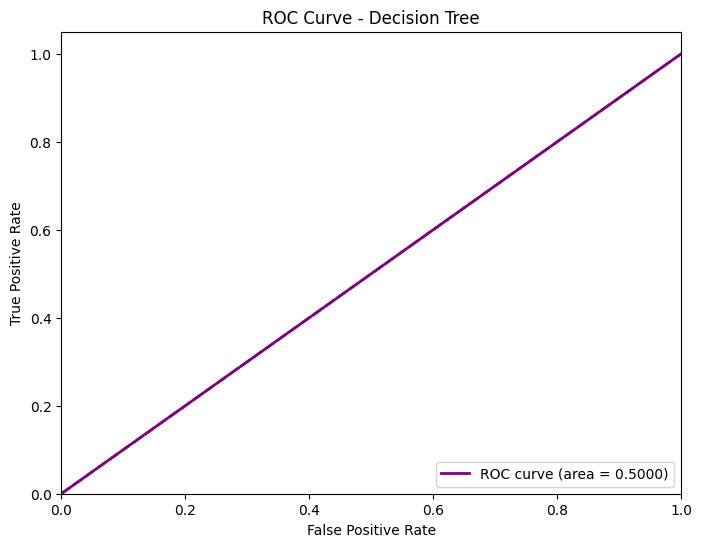

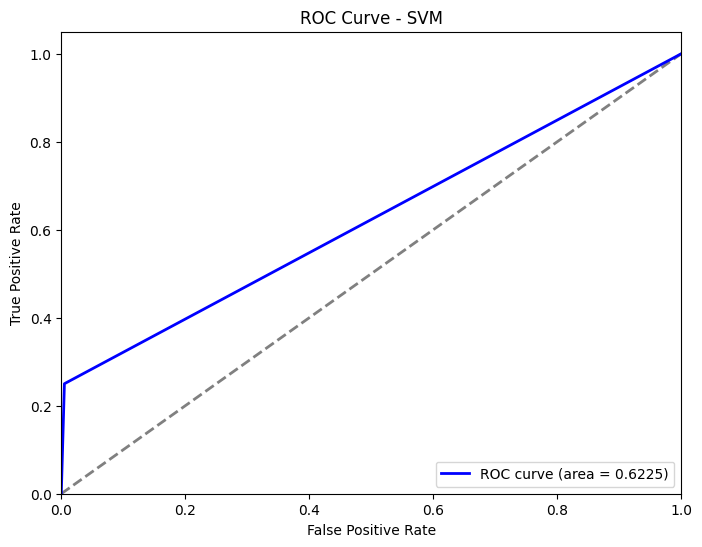

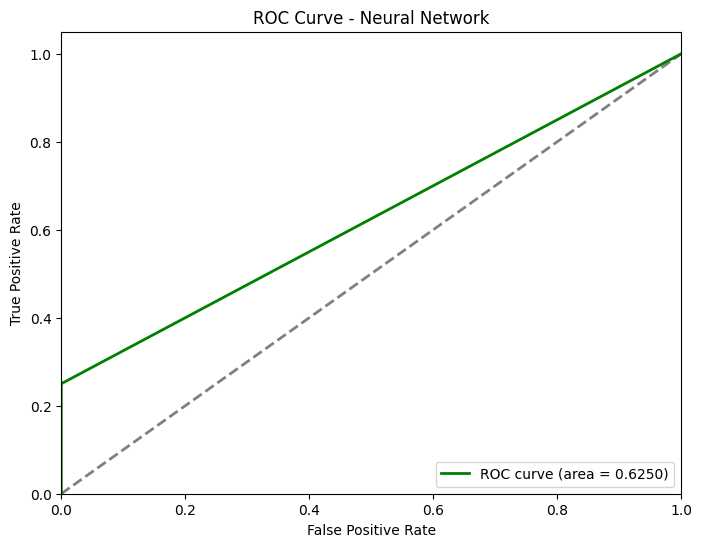

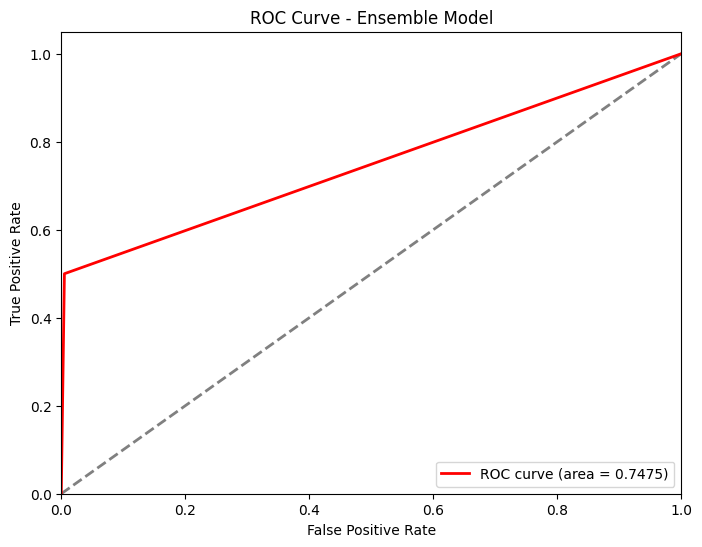

In [23]:
plot_roc_curve(dt_data["Actual"], dt_data["Prediction"], "ROC Curve - Decision Tree", 'purple')
plot_roc_curve(svm_data["Actual"], svm_data["Prediction"], "ROC Curve - SVM", 'blue')
plot_roc_curve(nn_data["Actual"], nn_data["Prediction"], "ROC Curve - Neural Network", 'green')
plot_roc_curve(em_data["Actual"], em_data["Prediction"], "ROC Curve - Ensemble Model", 'red')

## ROC - For Decision Tree, SVM, Neural Network (with SMOTE)

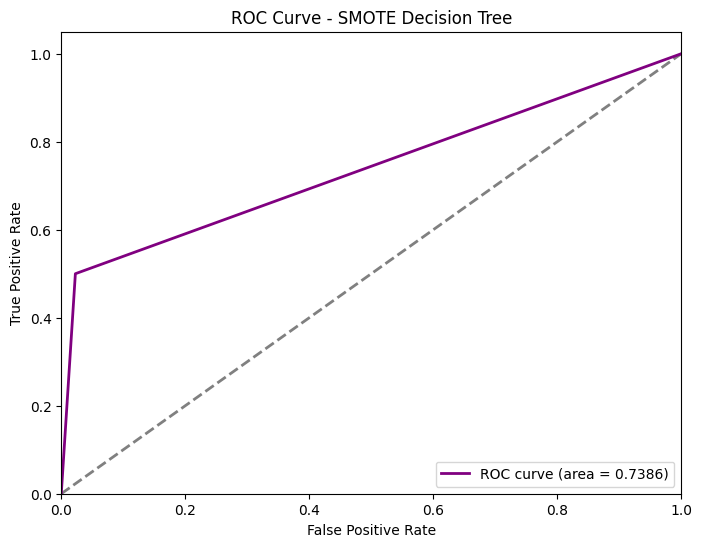

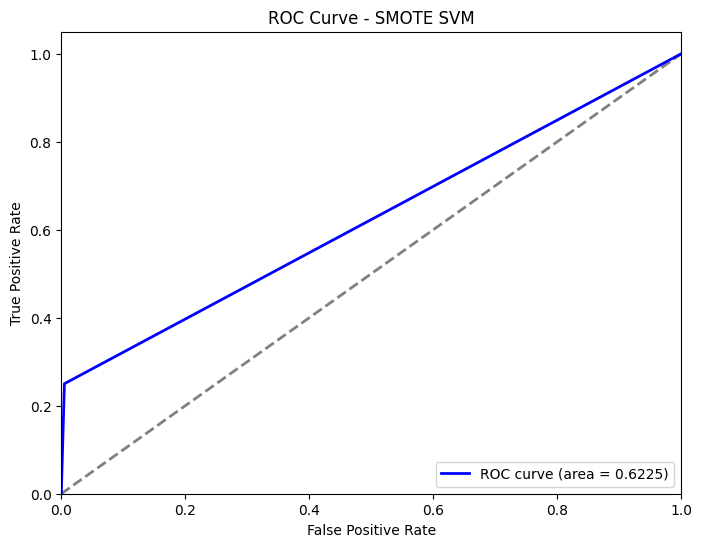

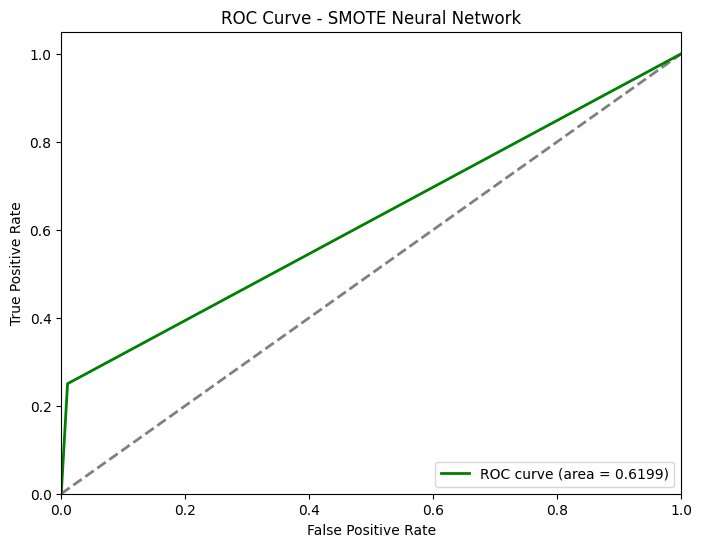

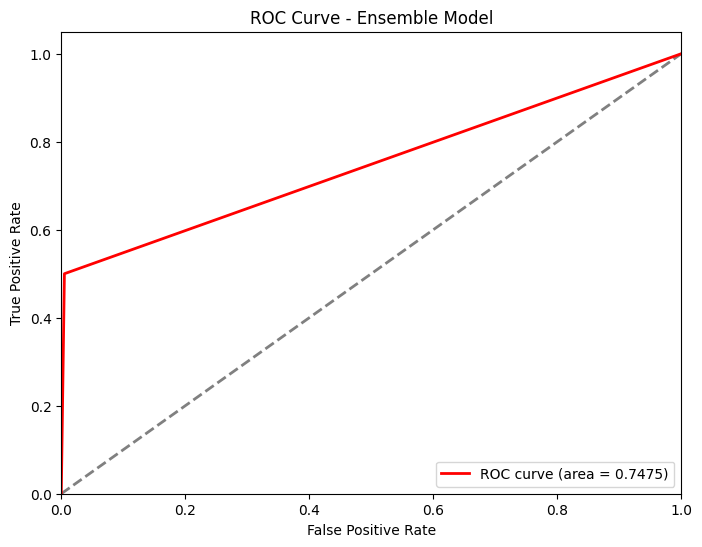

In [24]:
plot_roc_curve(smote_dt_data["Actual"], smote_dt_data["Prediction"], "ROC Curve - SMOTE Decision Tree", 'purple')
plot_roc_curve(smote_svm_data["Actual"], smote_svm_data["Prediction"], "ROC Curve - SMOTE SVM", 'blue')
plot_roc_curve(smote_nn_data["Actual"], smote_nn_data["Prediction"], "ROC Curve - SMOTE Neural Network", 'green')
plot_roc_curve(em_data["Actual"], em_data["Prediction"], "ROC Curve - Ensemble Model", 'red')

## Collated ROC Curve Plots

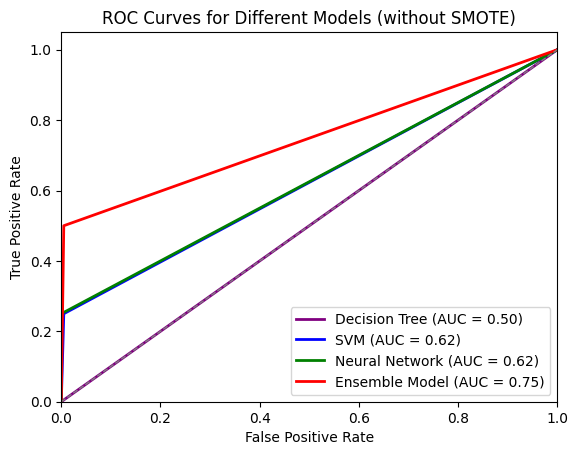

In [25]:
def plot_roc_curve(actual, prediction, title, color):
    fpr, tpr, _ = roc_curve(actual, prediction)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label='{} (AUC = {:.2f})'.format(title, roc_auc))

plot_roc_curve(dt_data["Actual"], dt_data["Prediction"], "Decision Tree", 'purple')
plot_roc_curve(svm_data["Actual"], svm_data["Prediction"], "SVM", 'blue')
plot_roc_curve(nn_data["Actual"], nn_data["Prediction"], "Neural Network", 'green')
plot_roc_curve(em_data["Actual"], em_data["Prediction"], "Ensemble Model", 'red')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models (without SMOTE)')
plt.legend(loc="lower right")
plt.savefig(roc_curves_path)
plt.show()


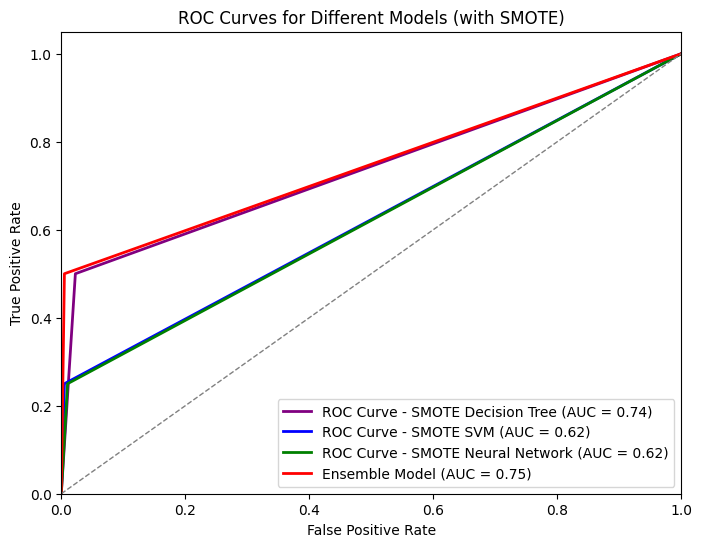

In [26]:
plt.figure(figsize=(8, 6))

plot_roc_curve(smote_dt_data["Actual"], smote_dt_data["Prediction"], "ROC Curve - SMOTE Decision Tree", 'purple')
plot_roc_curve(smote_svm_data["Actual"], smote_svm_data["Prediction"], "ROC Curve - SMOTE SVM", 'blue')
plot_roc_curve(smote_nn_data["Actual"], smote_nn_data["Prediction"], "ROC Curve - SMOTE Neural Network", 'green')
plot_roc_curve(em_data["Actual"], em_data["Prediction"], "Ensemble Model", 'red')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models (with SMOTE)')
plt.legend(loc="lower right")
plt.savefig(roc_curves_smote_path)
plt.show()

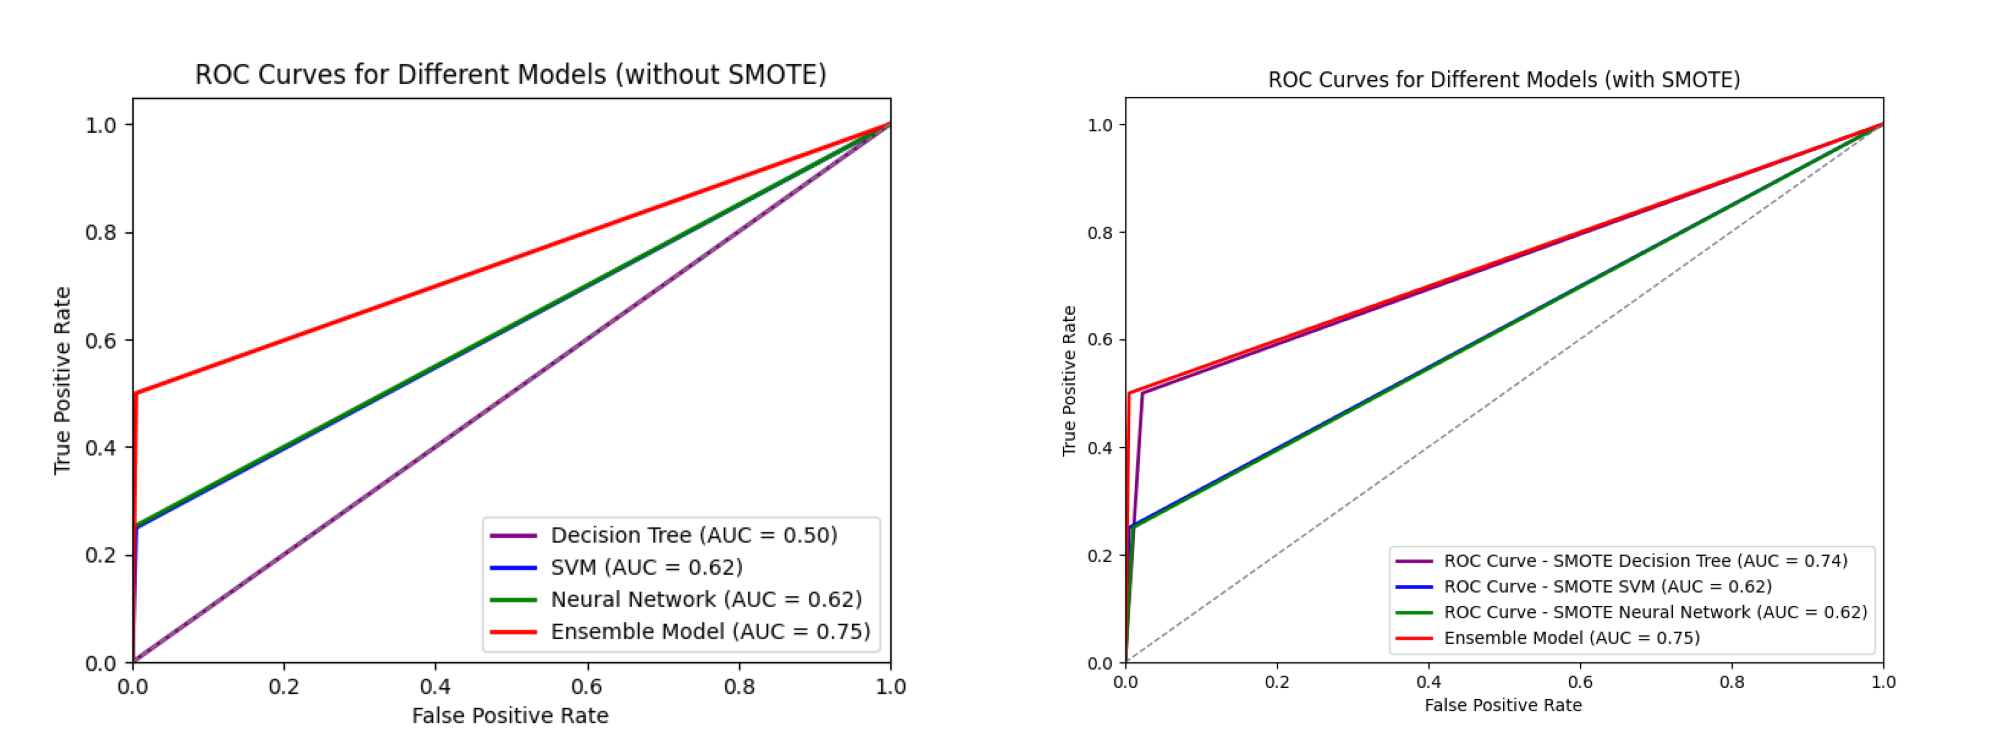

In [27]:
combine_plots([roc_curves_path, roc_curves_smote_path], "", combined_roc_curves_path, (20, 10), 0.68, 0.15, 14)

# Combined Confusion Matrix

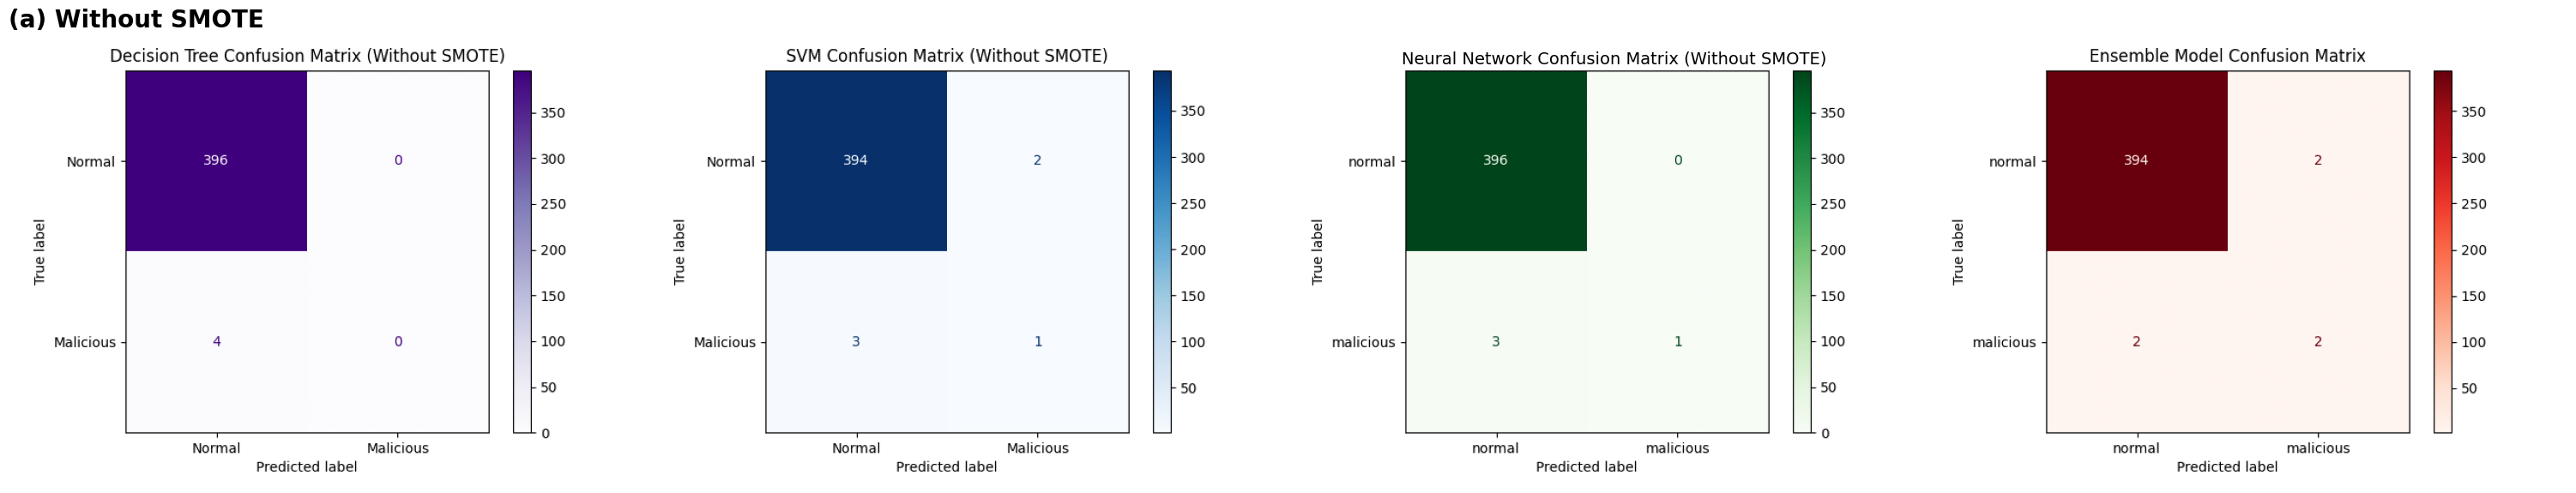

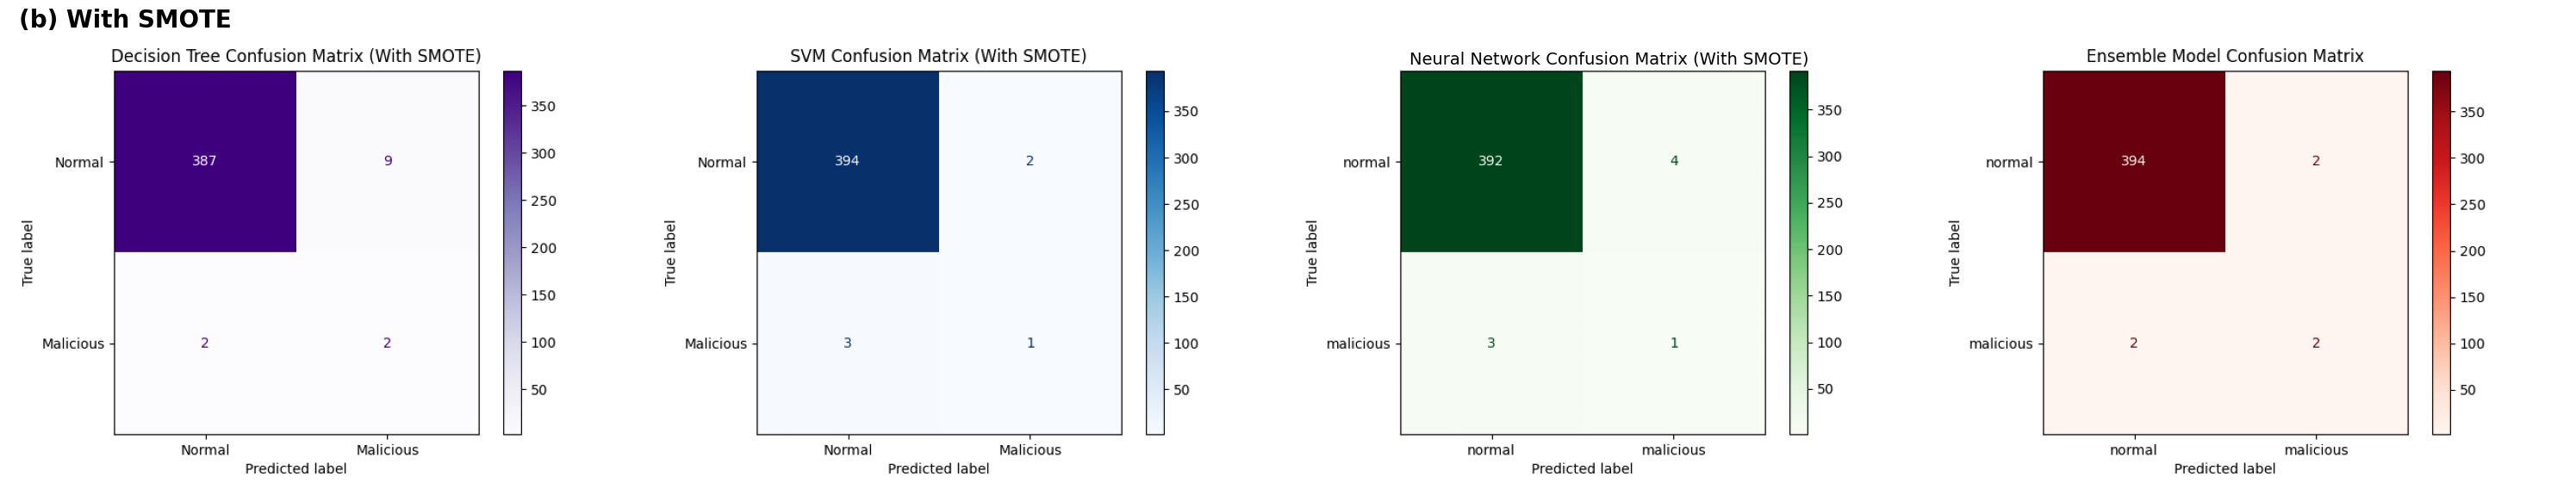

In [28]:
def combine_cm_plot(plot_paths, plot_title, save_file_path, subtitle):
    fig, ax = plt.subplots(1, len(plot_paths), figsize=(30, 10))
    plt.suptitle(plot_title, fontweight = "bold", y = 0.76, x = 0.05, fontsize = 20)

    for i, path in enumerate(plot_paths):
        ax[i].imshow(mpimg.imread(path))
        ax[i].axis('off')
        if i == 2:
            ax[2].set_title(subtitle, fontsize = 14, y = 0.88)
            
    plt.tight_layout()
    plt.savefig(save_file_path)
    plt.show()

combine_cm_plot([dt_confusion_matrix_path, svm_confusion_matrix_path, nn_confusion_matrix_path, em_confusion_matrix_path], "(a) Without SMOTE", confusion_matrix_path, 'Neural Network Confusion Matrix (Without SMOTE)')
combine_cm_plot([dt_smote_confusion_matrix_path, svm_smote_confusion_matrix_path, nn_smote_confusion_matrix_path, em_confusion_matrix_path], "(b) With SMOTE", smote_confusion_matrix_path, 'Neural Network Confusion Matrix (With SMOTE)')

# Combined Confidence Score Histogram

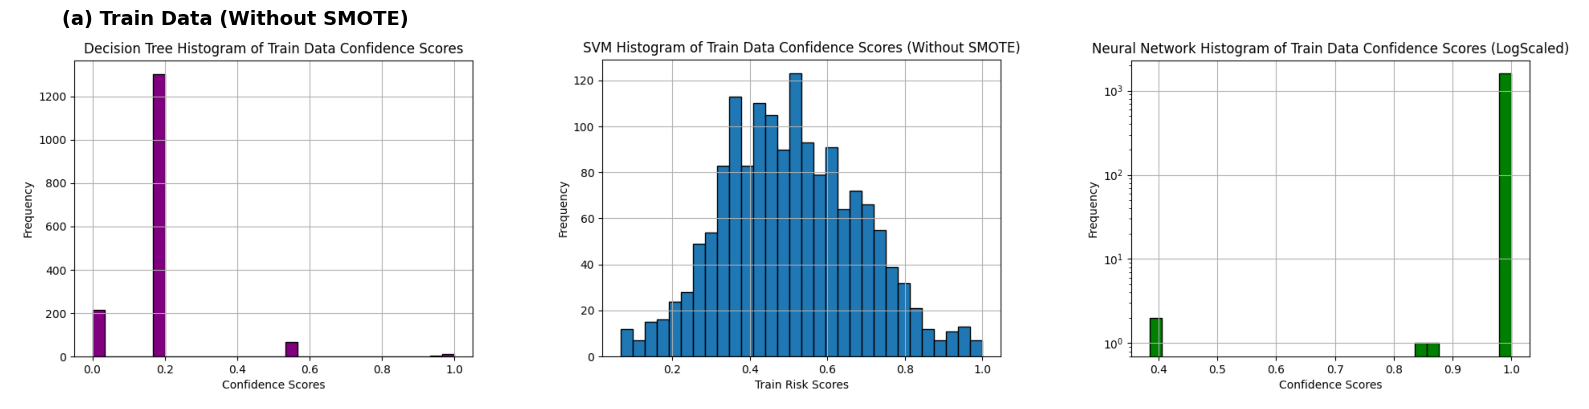

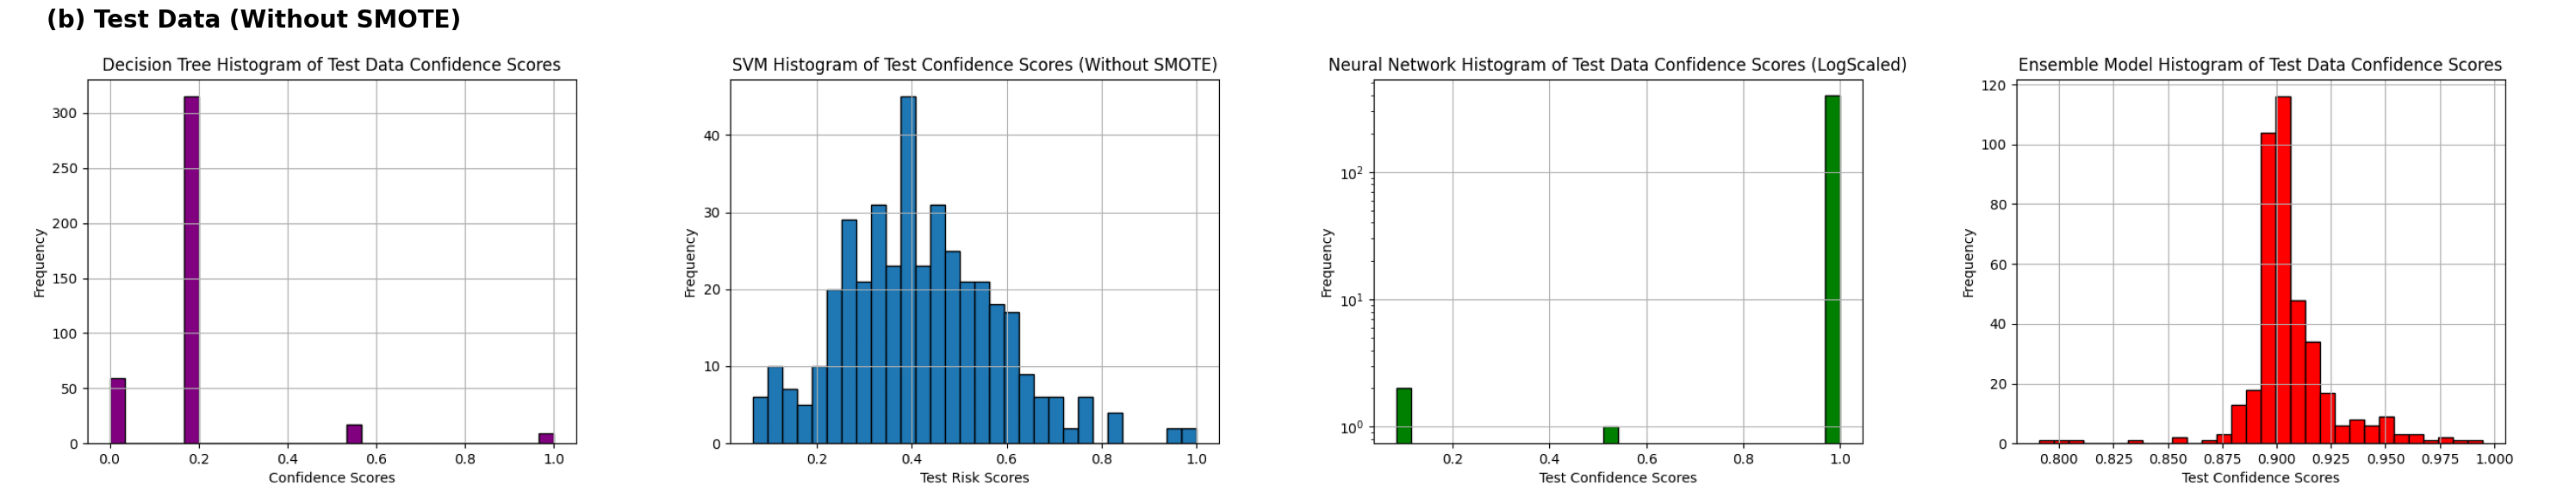

In [29]:
combine_plots([dt_train_confidence_score_path, svm_train_confidence_score_path, nn_train_confidence_score_path], "(a) Train Data (Without SMOTE)", train_confidence_score_path, (16, 10), 0.68, 0.15, 14)
combine_plots([dt_test_confidence_score_path, svm_test_confidence_score_path, nn_test_confidence_score_path, em_test_confidence_score_path], "(b) Test Data (Without SMOTE)", test_confidence_score_path, (30,10), 0.77, 0.1, 20)

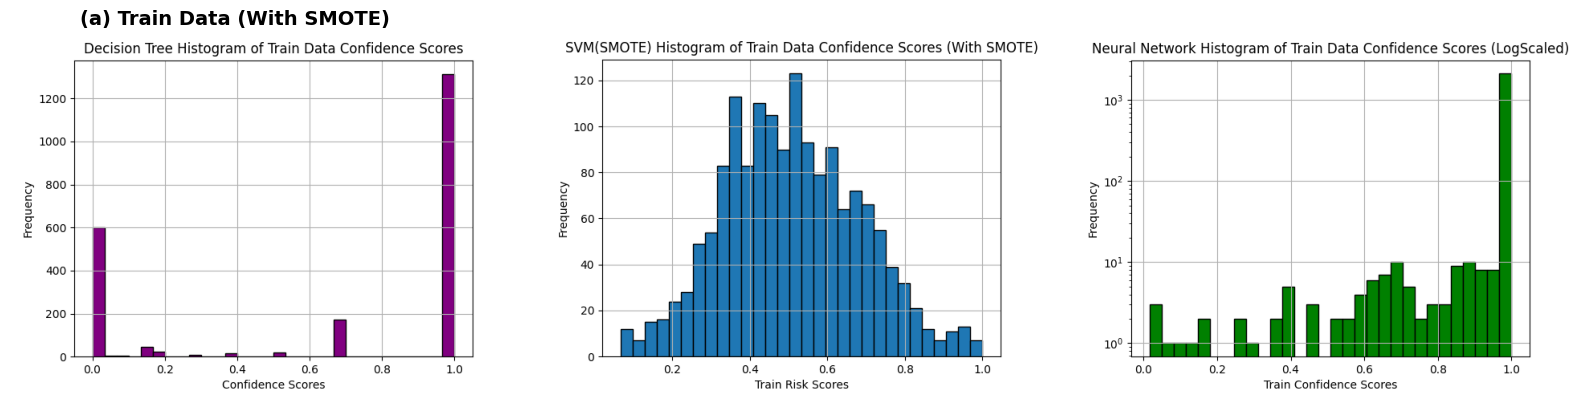

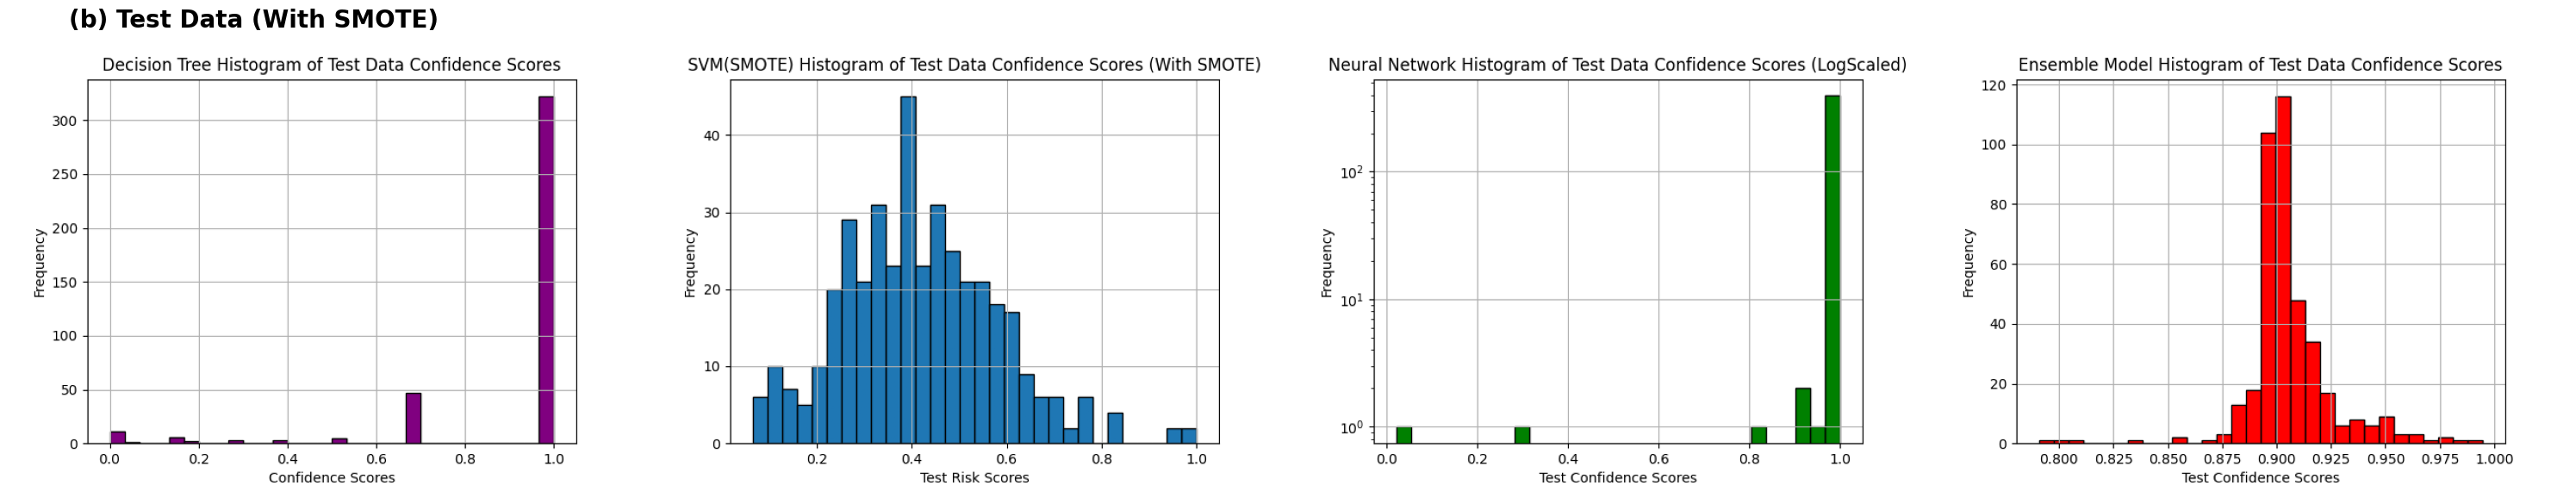

In [30]:
combine_plots([dt_smote_train_confidence_score_path, svm_smote_train_confidence_score_path, nn_smote_train_confidence_score_path], "(a) Train Data (With SMOTE)", smote_train_confidence_score_path, (16, 10), 0.68, 0.15, 14)
combine_plots([dt_smote_test_confidence_score_path, svm_smote_test_confidence_score_path, nn_smote_test_confidence_score_path, em_test_confidence_score_path], "(b) Test Data (With SMOTE)", smote_test_confidence_score_path, (30,10), 0.77, 0.1, 20)